# Finne punkt i nabolaget

for Ingvild

In [1]:
# test to check whether I can do it: 

import xarray as xr
import numpy as np
import pandas as pd
import proplot as plot
import pickle
import cartopy.crs as ccrs

Last inn noe eksempel data

In [2]:
regionPath = './../../1_Data/shapesNorwegianRegions_latlon/rr-region'
dataPath = './../../1_Data/qc_controlled/FROST_1960-2019.p'
data = pickle.load( open(dataPath, "rb" ) )


regionNames=['Inntrondelag','More og Romsdal','Dovre Nord Osterdal','Sogn',
             'Ostlandet','Sunnhordaland','Sor-Vestlandet', 'Ostfold',
             'Sorlandet','Varanger','Haalogaland','Finnmarksvidda','Trondelag Helgeland']

## You can change the start year: 
startYear = 1900
endYear   = 2015 #ends the last day in the year given

startIndx = np.nonzero(data['dateRange'].year==startYear)[0][0]
dateRange = data['dateRange']
end_indx = np.nonzero(dateRange.year == endYear)[0][-1]+1
flag      = data['flag']==1

if startYear == 1900: 
    flag2     = data['startDate'].year<1905
    flag      = ((flag==True) & (flag2==True))


normRange = pd.date_range(start='01-01-1960',end='31-12-1990',freq='d')
dateRange_monthly = pd.date_range(dateRange[0],dateRange[-1],freq='m')
startIndx_monthly = np.nonzero(dateRange_monthly.year==startYear)[0][0]
endIndx_monthly   = np.nonzero(dateRange_monthly.year==endYear)[0][-1]+1

dateRange_monthly  = dateRange_monthly[startIndx_monthly:endIndx_monthly]
dateRange          = dateRange[startIndx:end_indx]

stationID     = np.array(data['stationID'])[flag]
monthlyMean   = data['monthlyMean'][flag,startIndx_monthly:endIndx_monthly]
stationData   = data['stationData'][flag,startIndx:end_indx]
stationRegion = data['region'][flag]
stationLat    = data['stationLat'][flag]
stationLon    = data['stationLon'][flag]
stationName   = data['stationName'][flag]
regionNames_new = list(regionNames)
regionNames_new.remove('Ostfold')
ind_ostfold = np.argwhere(np.array(regionNames)=='Ostfold')[0][0]
ind_ostland = np.argwhere(np.array(regionNames)=='Ostlandet')[0][0]
stationRegion_new = np.copy(stationRegion)
stationRegion_new[stationRegion_new==float(ind_ostfold)]==ind_ostland
stationRegion_new[stationRegion_new>7]-=1

#%% now I need to load ERA-5 data
t2m = xr.open_dataset('/scratch/kjersti/1_reanalysis/ERA5/t2m_1979-2020.nc').isel(time=0)


fig,ax = plot.subplots(projection=ccrs.LambertConformal(central_longitude=6),figsize=(6,6))
ax.pcolormesh(t2m.lon,t2m.lat,t2m.t2m,transform=ccrs.PlateCarree())
ax.scatter(stationLon,stationLat)
ax.format(latlim=[57,71],lonlim=[4,31])



#%% select a random station, e.g. the first in the list. 
i = 1
lon_ = stationLon[i]
lat_ = stationLat[i]

# wan

In [7]:
import geopandas as gpd
from shapely.geometry import Point
pts = gpd.GeoSeries([Point(lon_,lat_)])

In [112]:
circle = pts.buffer(1)

Nå har jeg lat lon radius... og det er jo ikke helt riktig, så her må man gjøre noe projeksjonstriks. 

In [112]:
circle = pts.buffer(1)

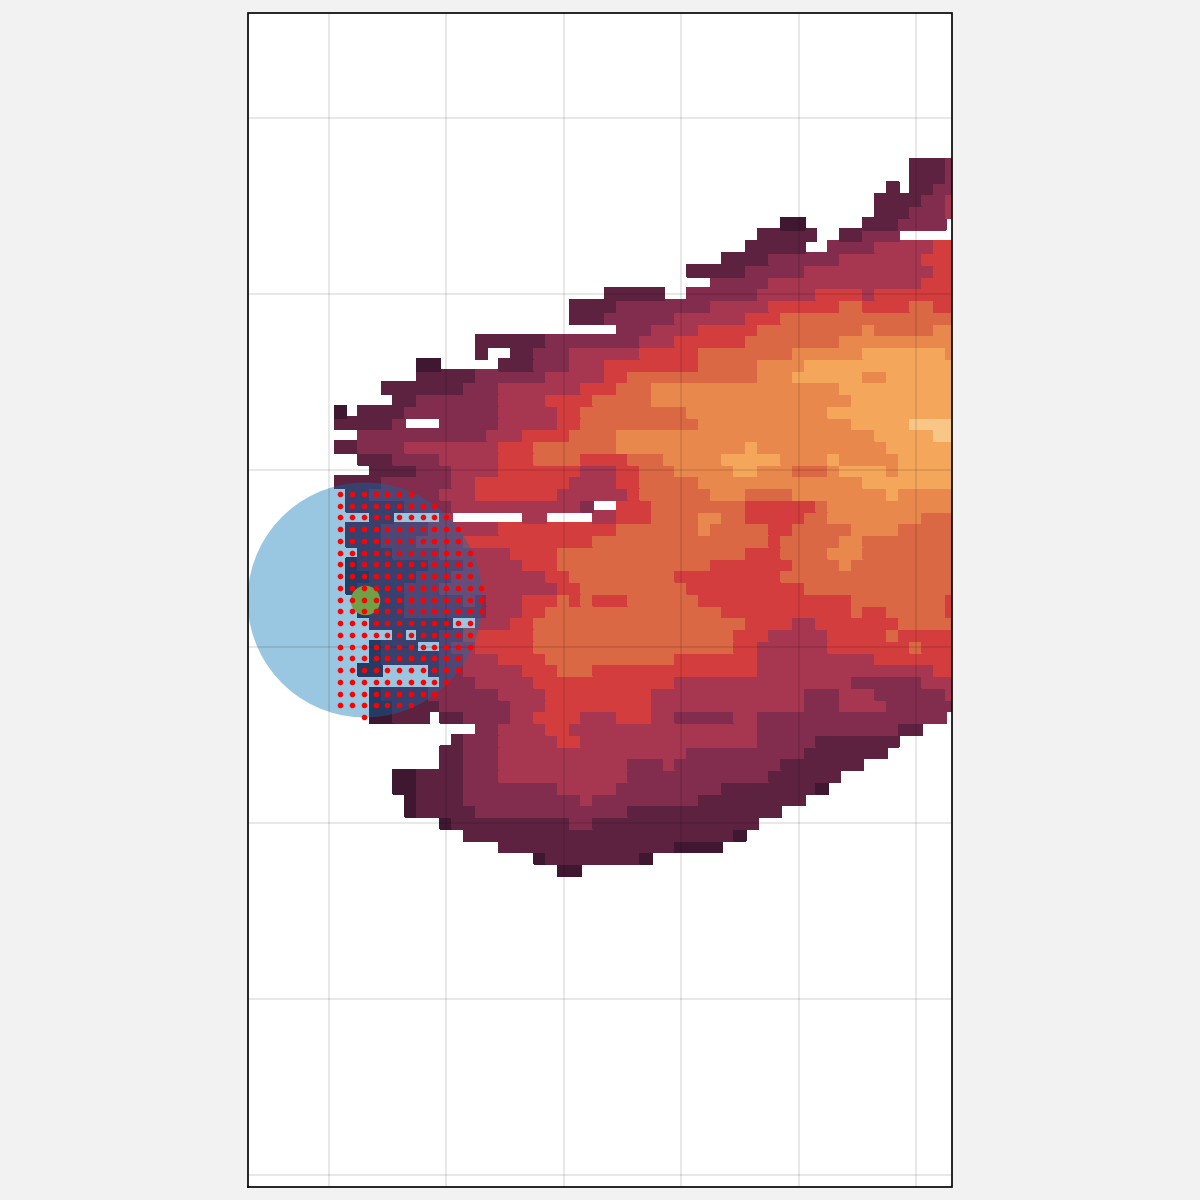

In [122]:
latsInCircle = []
lonsInCircle = []


fig,ax = plot.subplots(projection=ccrs.PlateCarree(),figsize=(6,6))
ax.pcolormesh(t2m.lon,t2m.lat,t2m.t2m,transform=ccrs.PlateCarree())
ax.scatter(lon_,lat_,color='y',s=100)

ax.add_geometries(circle,crs=ccrs.PlateCarree(),alpha=.4)

ax.format(latlim=[lat_-5,lat_+5],lonlim=[lon_-1,lon_+5])

for lats in t2m.sel(lat=slice(lat_-1,lat_+1)).lat: 
    for lons_ in t2m.sel(lon=slice(lon_-1,lon_+1)).lon: 
        p_ = Point(lons_,lats)
        a = circle.contains(p_)
        
        
        if a[0]: 
            
            latsInCircle.append(lats)
            lonsInCircle.append(lons_)
            
            ax.scatter(lons_,lats,color='r',zorder=10,s=2)